**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Постановка задачи:**
1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.
2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.
3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.
4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.
5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.
6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

**Описание датасета:** Для лабораторной работы был выбран датасет Кластеризация видов пингвинов (Clustering Penguins Species), в котором содержатся следующие признаки:
- culmen_length_mm, длина клюва, числовой признак, единица измерения: мм;
- culmen_depth_mm, высота надклювья, числовой признак, единица измерения: мм;
- flipper_length_mm, длина ласт, числовой признак, единица измерения: мм;
- body_mass_g, масса тела, числовой признак, единица измерения: гр;
- sex, пол, категориальный признак.

В данных нет меток класса, датасет предназначен именно для кластеризации.<br>
Виды пингвинов различаются по представленным критериям, поэтому кластеризация осмысленна.

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist

df = pd.read_csv('penguins.csv')

print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

Размер датасета: (344, 5)

Первые 5 строк:
   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
3               NaN              NaN                NaN          NaN     NaN
4              36.7             19.3              193.0       3450.0  FEMALE


In [68]:
print('Количество пропущенных значений:\n', df.isnull().sum())

Количество пропущенных значений:
 culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64


Пропущенные значения составляют не более 5% данных (примерно 2.6 %), следовательно, их можно просто удалить.

In [69]:
df = df.dropna(subset=['culmen_length_mm', 'culmen_depth_mm', 
                           'flipper_length_mm', 'body_mass_g'])

df = df.dropna(subset=['sex'])

df['sex'] = df['sex'].map({'FEMALE': 0, 'MALE': 1, '.': 1})

print('Проверка пропущенных значений:\n', df.isnull().sum())

Проверка пропущенных значений:
 culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


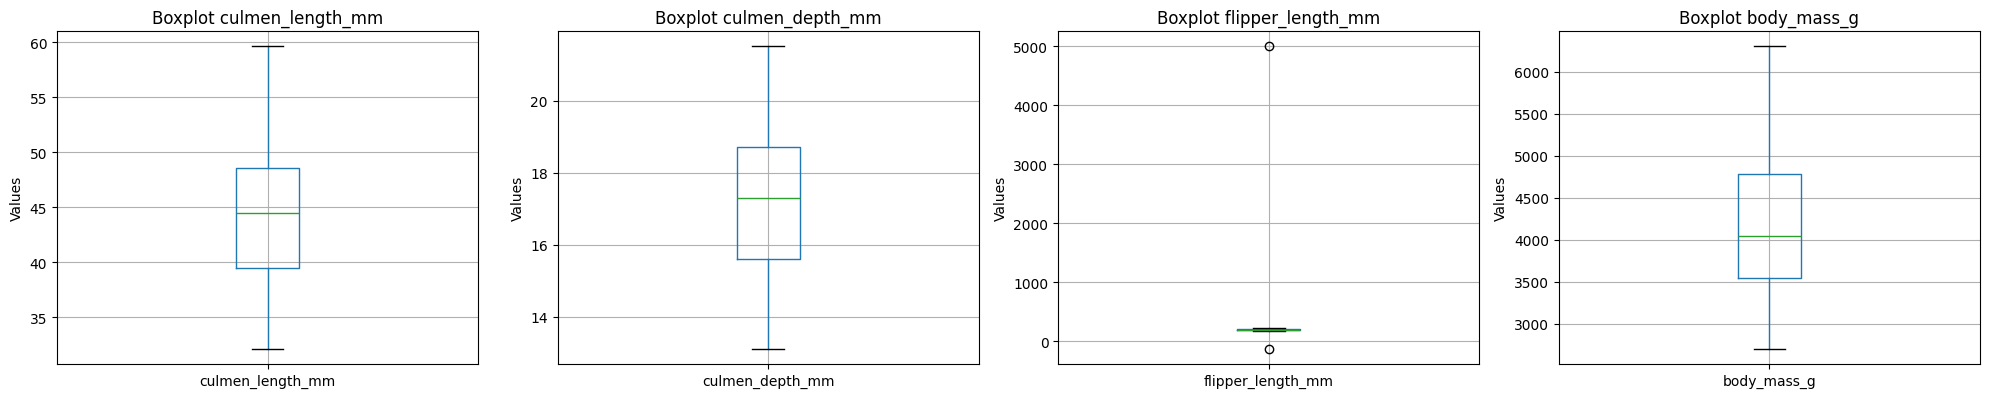

In [70]:
features = df.columns[:4]
n_features = len(features)

fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.ravel()

for i, feature in enumerate(features):
    if i < len(axes):
        df.boxplot(column=feature, ax=axes[i])
        axes[i].set_title(f'Boxplot {feature}')
        axes[i].set_ylabel('Values')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

В результате построения ящиков с усами можно заметить, что признак flipper_length_mm содержит выбросы. Можно попробовать избавиться от них, ограничив диапазон данных.

In [71]:
print(df[df["flipper_length_mm"] > 4000])
print(df[df["flipper_length_mm"] < 0])

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  sex
9              42.0             20.2             5000.0       4250.0    1
    culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  sex
14              34.6             21.1             -132.0       4400.0    1


В flipper_length_mm всего 2 выброса, поэтому, действительно, можно просто исключить их.

In [72]:
df = df.drop([9, 14])

print("Размер датасета:", df.shape)

Размер датасета: (333, 5)


В результате предобработки данных размер датасета сократился с 344 до 333 (на 3.2%), что вполне приемлемо.

In [73]:
print("Дескриптивный анализ:")

summary = pd.DataFrame({
    "Среднее": df.mean(numeric_only=True),
    "Медиана": df.median(numeric_only=True),
    "Мода": df.mode().iloc[0],
    "Ст. отклонение": df.std(numeric_only=True),
    "Мин": df.min(),
    "Макс": df.max()
})

print(summary.round(2))

Дескриптивный анализ:
                   Среднее  Медиана    Мода  Ст. отклонение     Мин    Макс
culmen_length_mm     44.02     44.5    41.1            5.44    32.1    59.6
culmen_depth_mm      17.15     17.3    17.0            1.96    13.1    21.5
flipper_length_mm   201.02    197.0   190.0           14.04   172.0   231.0
body_mass_g        4208.48   4050.0  3800.0          805.98  2700.0  6300.0
sex                   0.50      1.0     1.0            0.50     0.0     1.0


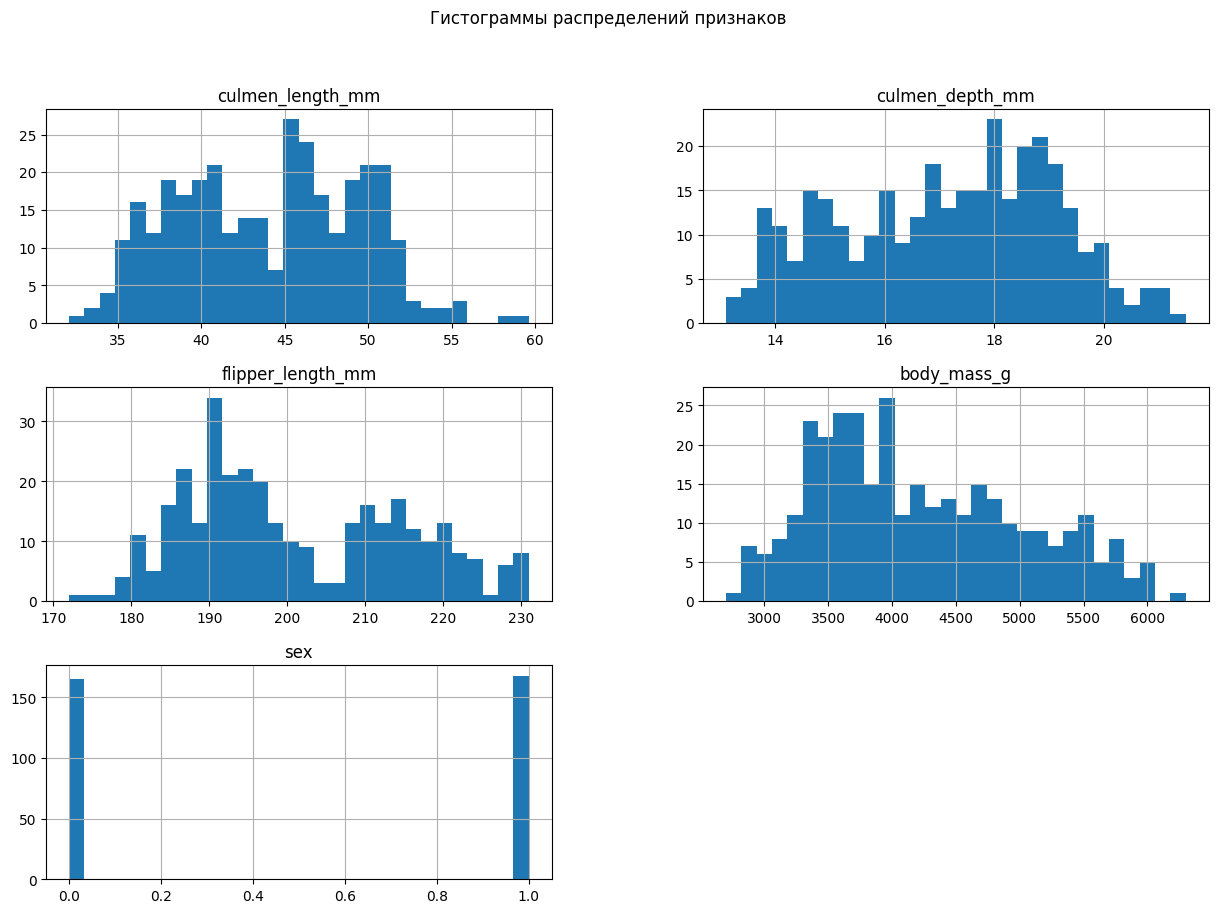

In [74]:
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Гистограммы распределений признаков")
plt.show()

Распределения признаков не согласуются с нормальным, кроме того, признаки представлены в разных единицах измерения, поэтому необходимо применить стандартизацию.

In [75]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)

print("Статистика после обработки:")
print(df_scaled.describe().round(2))

Статистика после обработки:
       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
count            333.00           333.00             333.00       333.00   
mean               0.00            -0.00               0.00        -0.00   
std                1.00             1.00               1.00         1.00   
min               -2.19            -2.07              -2.07        -1.87   
25%               -0.83            -0.79              -0.79        -0.82   
50%                0.09             0.08              -0.29        -0.20   
75%                0.84             0.79               0.85         0.74   
max                2.87             2.22               2.14         2.60   

          sex  
count  333.00  
mean     0.00  
std      1.00  
min     -1.01  
25%     -1.01  
50%      0.99  
75%      0.99  
max      0.99  


<Figure size 2000x2000 with 0 Axes>

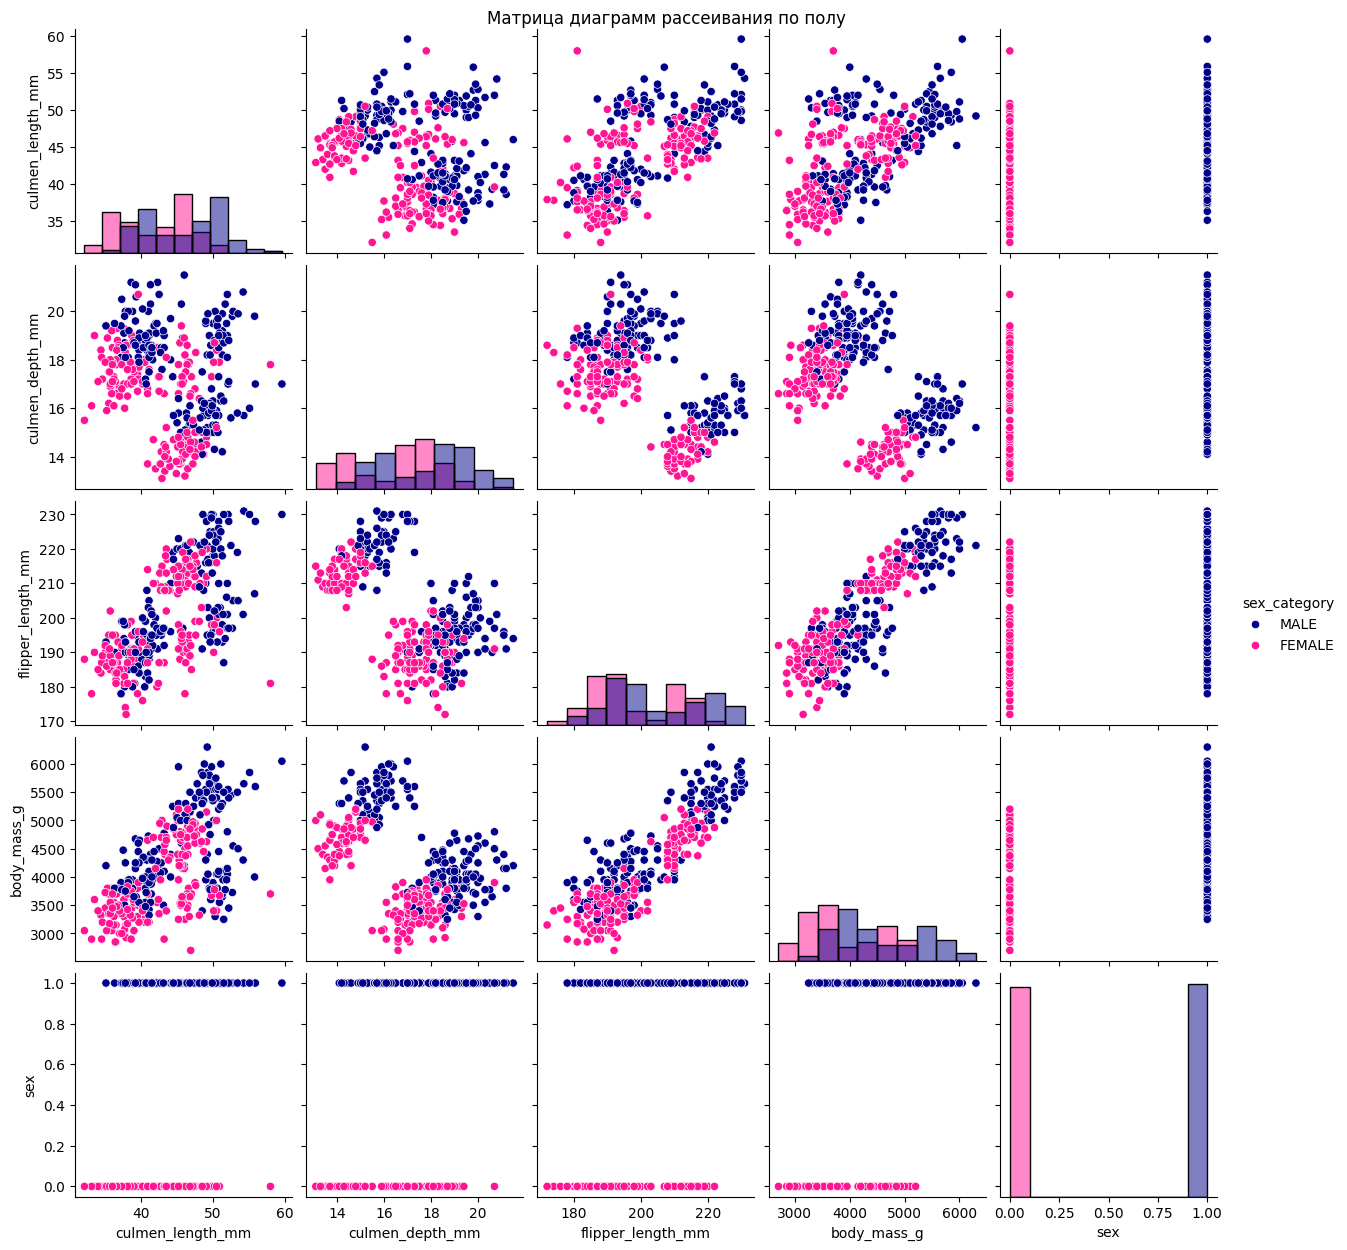

In [92]:
df_original_plot = df.copy()
df_original_plot['sex_category'] = df_original_plot['sex'].map({0: 'FEMALE', 1: 'MALE'})

plt.figure(figsize=(20, 20))
sns.pairplot(df_original_plot, hue='sex_category', 
             palette={'FEMALE': 'deeppink', 'MALE': 'darkblue'},
             diag_kind='hist')
plt.suptitle('Матрица диаграмм рассеивания по полу', y=1)
plt.show()

По диаграммам рассеивания можно предположить, что оптимальное количество кластеров - 2-3.<br>
На диаграммах с двумя кластерами можно заметить, что они слегка вытянутые, но при этом у них вполне возможно определить центры.<br>
На диаграммах с тремя кластерами похоже, что кластеры с центрами накладываются на разреженный фон из редко расположенных объектов.<br>
В каждом кластере наблюдается примерно равное соотношение пингвинов женского и мужского пола.

Можно попробовать использовать метод k-средних, так как данные представляют собой отдельные "облака". Однако эти "облака" немного разного размера и присутствуют обособленные точки, которые могут плохо влиять на работу алгоритма.<br>
Алгоритм DBSCAN лучше подходит для датасета, так как он создан как раз для работы с "облаками", которые разделены данными с низкой плотностью. Размер датасета позволяет использовать данный метод.<br>

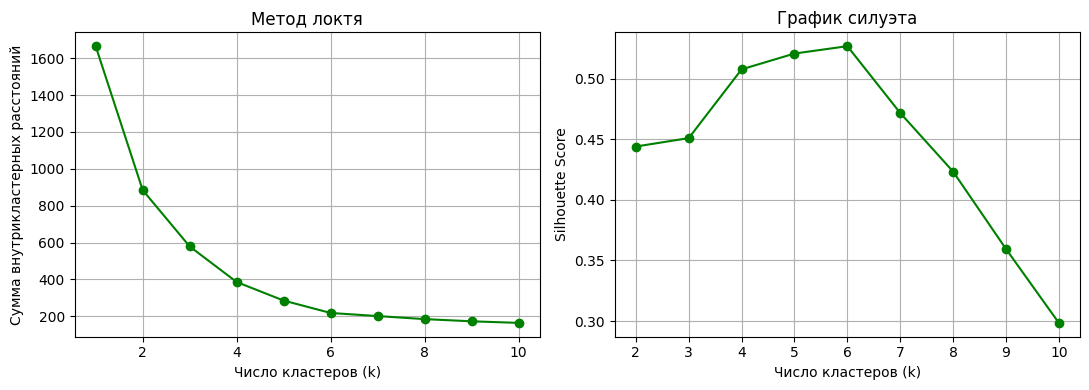

In [77]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), inertia, 'go-')
plt.title("Метод локтя")
plt.xlabel("Число кластеров (k)")
plt.ylabel("Сумма внутрикластерных расстояний")
plt.grid(True)

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'go-')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('График силуэта')
plt.grid(True)
plt.tight_layout()
plt.show()

По методу локтя можно выбрать 3-4 кластера, так как после 4 график изменяется гораздо медленнее.<br>
По графику силуэта видно, что сильной скачок происходит в точке 4, а далее график растет очень медленно.<br>
Таким образом, оптимальным количеством кластеров будет 4.

In [78]:
k = 4

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

dbscan = DBSCAN(eps=0.95, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

In [79]:
def calculate_cluster_metrics(X, labels, method_name):
    unique_labels = np.unique(labels)
    metrics = {}
    
    if len(unique_labels) > 1:
        metrics['silhouette'] = silhouette_score(X, labels)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    else:
        metrics['silhouette'] = metrics['calinski_harabasz'] = metrics['davies_bouldin'] = np.nan
    
    cluster_stats = {}
    for label in unique_labels:
        if label == -1:
            continue
            
        cluster_points = X[labels == label]
        if len(cluster_points) < 2:
            continue
            
        centroid = np.mean(cluster_points, axis=0)
        distances_to_center = np.linalg.norm(cluster_points - centroid, axis=1)
        
        cluster_stats[label] = {
            'size': len(cluster_points),
            'centroid': centroid,
            'compactness': np.mean(distances_to_center),
            'intra_mean': np.mean(pdist(cluster_points)),
            'radius': np.max(distances_to_center)
        }

    if len(cluster_stats) > 1:
        centroids = [stats['centroid'] for stats in cluster_stats.values()]
        inter_distances = pdist(centroids)
        metrics['mean_inter_distance'] = np.mean(inter_distances)
        metrics['min_inter_distance'] = np.min(inter_distances)
    else:
        metrics['mean_inter_distance'] = metrics['min_inter_distance'] = np.nan
    
    return metrics, cluster_stats
kmeans_metrics, kmeans_stats = calculate_cluster_metrics(X_scaled, kmeans_labels, "K-means")
dbscan_metrics, dbscan_stats = calculate_cluster_metrics(X_scaled, dbscan_labels, "DBSCAN")

print("Внутренние метрики качества кластеризации")
metrics_comparison = pd.DataFrame({
    'Метод': ['K-means', 'DBSCAN'],
    'Кластеры': [len(kmeans_stats), len(dbscan_stats)],
    'Выбросы': [0, np.sum(dbscan_labels == -1)],
    'Silhouette': [
        f"{kmeans_metrics['silhouette']:.4f}" if not np.isnan(kmeans_metrics['silhouette']) else 'N/A',
        f"{dbscan_metrics['silhouette']:.4f}" if not np.isnan(dbscan_metrics['silhouette']) else 'N/A'
    ],
    'Calinski-Harabasz': [
        f"{kmeans_metrics['calinski_harabasz']:.2f}" if not np.isnan(kmeans_metrics['calinski_harabasz']) else 'N/A',
        f"{dbscan_metrics['calinski_harabasz']:.2f}" if not np.isnan(dbscan_metrics['calinski_harabasz']) else 'N/A'
    ],
    'Davies-Bouldin': [
        f"{kmeans_metrics['davies_bouldin']:.4f}" if not np.isnan(kmeans_metrics['davies_bouldin']) else 'N/A',
        f"{dbscan_metrics['davies_bouldin']:.4f}" if not np.isnan(dbscan_metrics['davies_bouldin']) else 'N/A'
    ]
})

print(metrics_comparison.to_string(index=False))

print("\nАнализ структуры кластеров K-means")
kmeans_analysis = []
for label, stats in kmeans_stats.items():
    kmeans_analysis.append({
        'Кластер': label,
        'Размер': stats['size'],
        'Доля, %': f"{(stats['size'] / len(X_scaled) * 100):.1f}",
        'Компактность': f"{stats['compactness']:.4f}",
        'Внутр. расстояние': f"{stats['intra_mean']:.4f}",
        'Радиус': f"{stats['radius']:.4f}"
    })

kmeans_df = pd.DataFrame(kmeans_analysis)
print(kmeans_df.to_string(index=False))
if not np.isnan(kmeans_metrics['mean_inter_distance']):
    print(f"\nСреднее межкластерное расстояние: {kmeans_metrics['mean_inter_distance']:.4f}")
    print(f"Минимальное межкластерное расстояние: {kmeans_metrics['min_inter_distance']:.4f}")

print("\nАнализ структуры кластеров DBSCAN")
if dbscan_stats:
    dbscan_analysis = []
    total_points = len(dbscan_labels)
    noise_points = np.sum(dbscan_labels == -1)
    valid_points = total_points - noise_points
    
    for label, stats in dbscan_stats.items():
        dbscan_analysis.append({
            'Кластер': label,
            'Размер': stats['size'],
            'Доля валидных, %': f"{(stats['size'] / valid_points * 100):.1f}",
            'Компактность': f"{stats['compactness']:.4f}",
            'Внутр. расстояние': f"{stats['intra_mean']:.4f}",
            'Радиус': f"{stats['radius']:.4f}"
        })
    
    dbscan_df = pd.DataFrame(dbscan_analysis)
    print(dbscan_df.to_string(index=False))
    print(f"\nВыбросы: {noise_points} точек ({(noise_points/total_points*100):.1f}% данных)")
    
    if not np.isnan(dbscan_metrics['mean_inter_distance']):
        print(f"Среднее межкластерное расстояние: {dbscan_metrics['mean_inter_distance']:.4f}")
        print(f"Минимальное межкластерное расстояние: {dbscan_metrics['min_inter_distance']:.4f}")
else:
    print("DBSCAN не обнаружил кластеров")

Внутренние метрики качества кластеризации
  Метод  Кластеры  Выбросы Silhouette Calinski-Harabasz Davies-Bouldin
K-means         4        0     0.5076            363.79         0.7631
 DBSCAN         4        2     0.4908            278.62         1.1554

Анализ структуры кластеров K-means
 Кластер  Размер Доля, % Компактность Внутр. расстояние Радиус
       0     106    31.8       1.2206            1.6718 2.3864
       1      58    17.4       0.6045            0.8554 1.1349
       2     107    32.1       1.0592            1.4824 3.3408
       3      62    18.6       0.7766            1.1051 2.1990

Среднее межкластерное расстояние: 3.2131
Минимальное межкластерное расстояние: 2.3960

Анализ структуры кластеров DBSCAN
 Кластер  Размер Доля валидных, % Компактность Внутр. расстояние Радиус
       0     106             32.0       1.2206            1.6718 2.3864
       1     105             31.7       1.0271            1.4342 2.1147
       2      58             17.5       0.6045          

**Сравнение методов:**
На основании полученных метрик качества, K-means показывает несколько лучшие результаты для данного набора данных, чем DBSCAN.
- Silhouette (0.5076/0.4908): Оба значения показывают средние результаты, но у K-means этот показатель чуть выше. Это означает, что в среднем объекты в кластерах K-means немного лучше сгруппированы и сильнее отделены от других кластеров.
- Calinski-Harabasz (363.79/278.62): Значительно более высокий показатель у K-means указывает на то, что кластеры более плотные и хорошо разделены (высокая дисперсия между кластерами по сравнению с дисперсией внутри них).
- Davies-Bouldin (0.7631/1.1554): Более низкий показатель (что лучше) у K-means подтверждает выводы двух предыдущих метрик: кластеры более компактны и дальше друг от друга.

Также, DBSCAN идентифицировал 2 выброса, в то время как K-means принудительно отнес все точки к кластерам. Это важное преимущество DBSCAN, так как эти две точки могут быть шумом или действительно аномальными наблюдениями.

**Анализ кластеров K-means:**
- Кластер 0 и Кластер 2: крупнейшие кластеры (~32% данных каждый). Вероятно, это основные, но внутренне неоднородные группы данных. Возможно, они сами могут быть разделены на подгруппы, но алгоритм K-means с K=4 этого не делает.
- Кластер 1: Низкая компактность (0.60) и малый радиус (1.13) означают, что все объекты внутри него лежат очень близко друг к другу. Это хорошо определенная группа объектов, сильно отличающаяся от остальных.
- Кластер 3: Похож на кластер 1, но чуть менее компактный. Это вторая хорошо выделенная группа.<br>
Минимальное расстояние=2.396, это расстояние между двумя самыми близкими кластерами. Оно сопоставимо с радиусами самых больших кластеров (2.39 и 3.34), это указывает на то, что эти кластеры не идеально разделены и их границы могут быть немного размыты.
Среднее расстояние=3.213 - в среднем кластеры находятся на хорошем расстоянии друг от друга, что подтверждается высоким значением Calinski-Harabasz.


**Анализ кластеров DBSCAN:**
- DBSCAN разделил большой и неоднородный кластер 2 от K-means на два отдельных кластера: кластер 1 (105 точек, 31.7%) и, судя по всему, оставил часть в качестве выбросов (2 точки). Новый кластер 1 имеет лучшие показатели компактности (1.027) и радиуса (2.115), чем исходный кластер 2 от K-means. Это означает, что DBSCAN смог найти более естественную границу внутри этого размытого "облака" точек, улучшив его внутреннюю структуру.
- Кластеры 0, 2, 3 в DBSCAN практически идентичны Кластерам 0, 1, 3 из K-means по всем показателям. Это говорит о том, что эти три группы являются очень устойчивыми и явными структурами в данных, которые оба алгоритма находят одинаково.



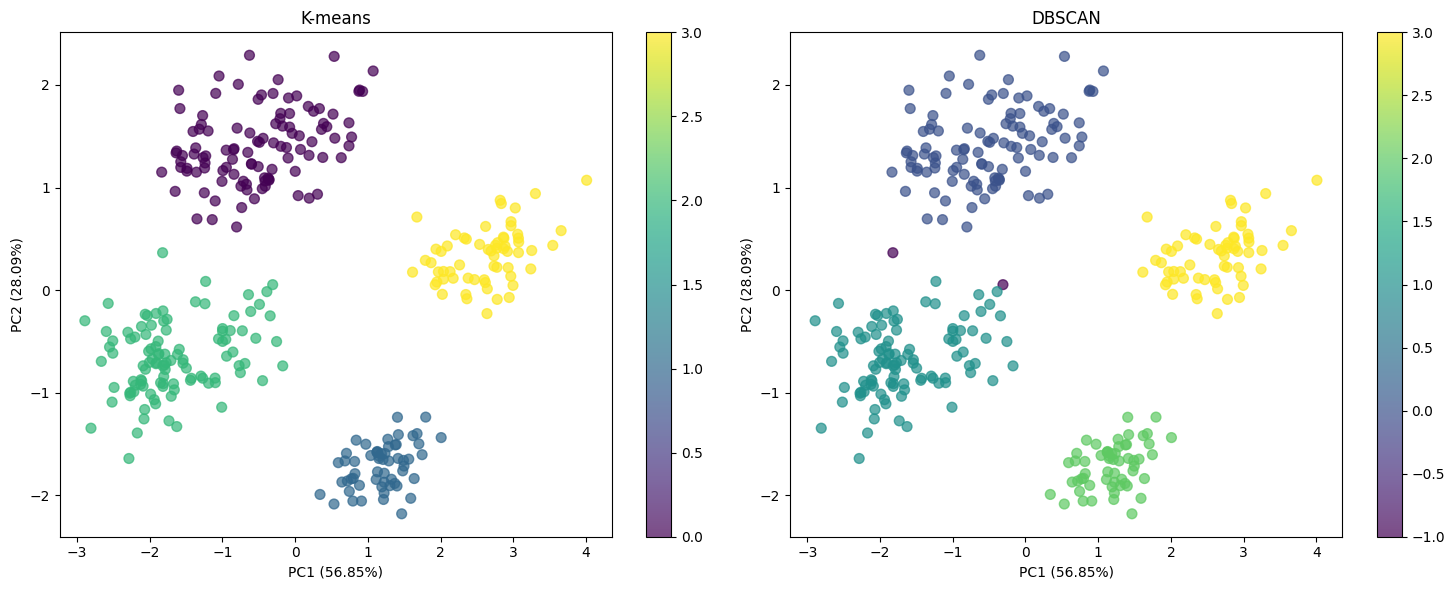

In [80]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)
axes[0].set_title('K-means')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')

plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7, s=50)
axes[1].set_title('DBSCAN')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')

plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

centroids = scaler.inverse_transform(kmeans.cluster_centers_)

In [81]:
print("Центры кластеров K-means")
centroids_analysis = []
for i, centroid in enumerate(centroids):
    centroid_info = {'Кластер': i, 'Размер': kmeans_stats[i]['size']}
    for j, feature in enumerate(df_scaled.columns):
        centroid_info[feature] = f"{centroid[j]:.2f}"
    centroids_analysis.append(centroid_info)

centroids_df_detailed = pd.DataFrame(centroids_analysis)
print(centroids_df_detailed.to_string(index=False))

Центры кластеров K-means
 Кластер  Размер culmen_length_mm culmen_depth_mm flipper_length_mm body_mass_g  sex
       0     106            43.88           19.11            194.76     4006.60 1.00
       1      58            45.56           14.24            212.71     4679.74 0.00
       2     107            40.22           17.61            189.05     3419.16 0.00
       3      62            49.39           15.72            221.47     5475.00 1.00


Кластер 2 (107 особей) и Кластер 0 (106 особей): У обоих кластеров самые маленькие значения flipper_length_mm (189-195 см) и body_mass_g (3420-4007 г) по сравнению с другими кластерами. Это указывает на вид, который в целом мельче. Ключевое различие между кластерами 2 и 0 — половой диморфизм.

Кластер 1 (58 особей) и Кластер 3 (62 особи): У обоих кластеров значительно большие значения flipper_length_mm (213-221 см) и body_mass_g (4680-5475 г). Это явно более крупный и мощный вид.

Алгоритм четко разделил данные по двум основным осям: вид и пол.

Сравнительная таблица метрик качества кластеризации K-means
 K Silhouette Calinski-Harabasz Davies-Bouldin Ср. межкл. расст. Мин. межкл. расст.
 2     0.4439            292.27         0.9728            3.1894             3.1894
 3     0.4509            309.87         0.9121            3.0651             2.3960
 4     0.5076            363.79         0.7631            3.2131             2.3960
 5     0.5206            397.10         0.7267            3.1357             2.0565


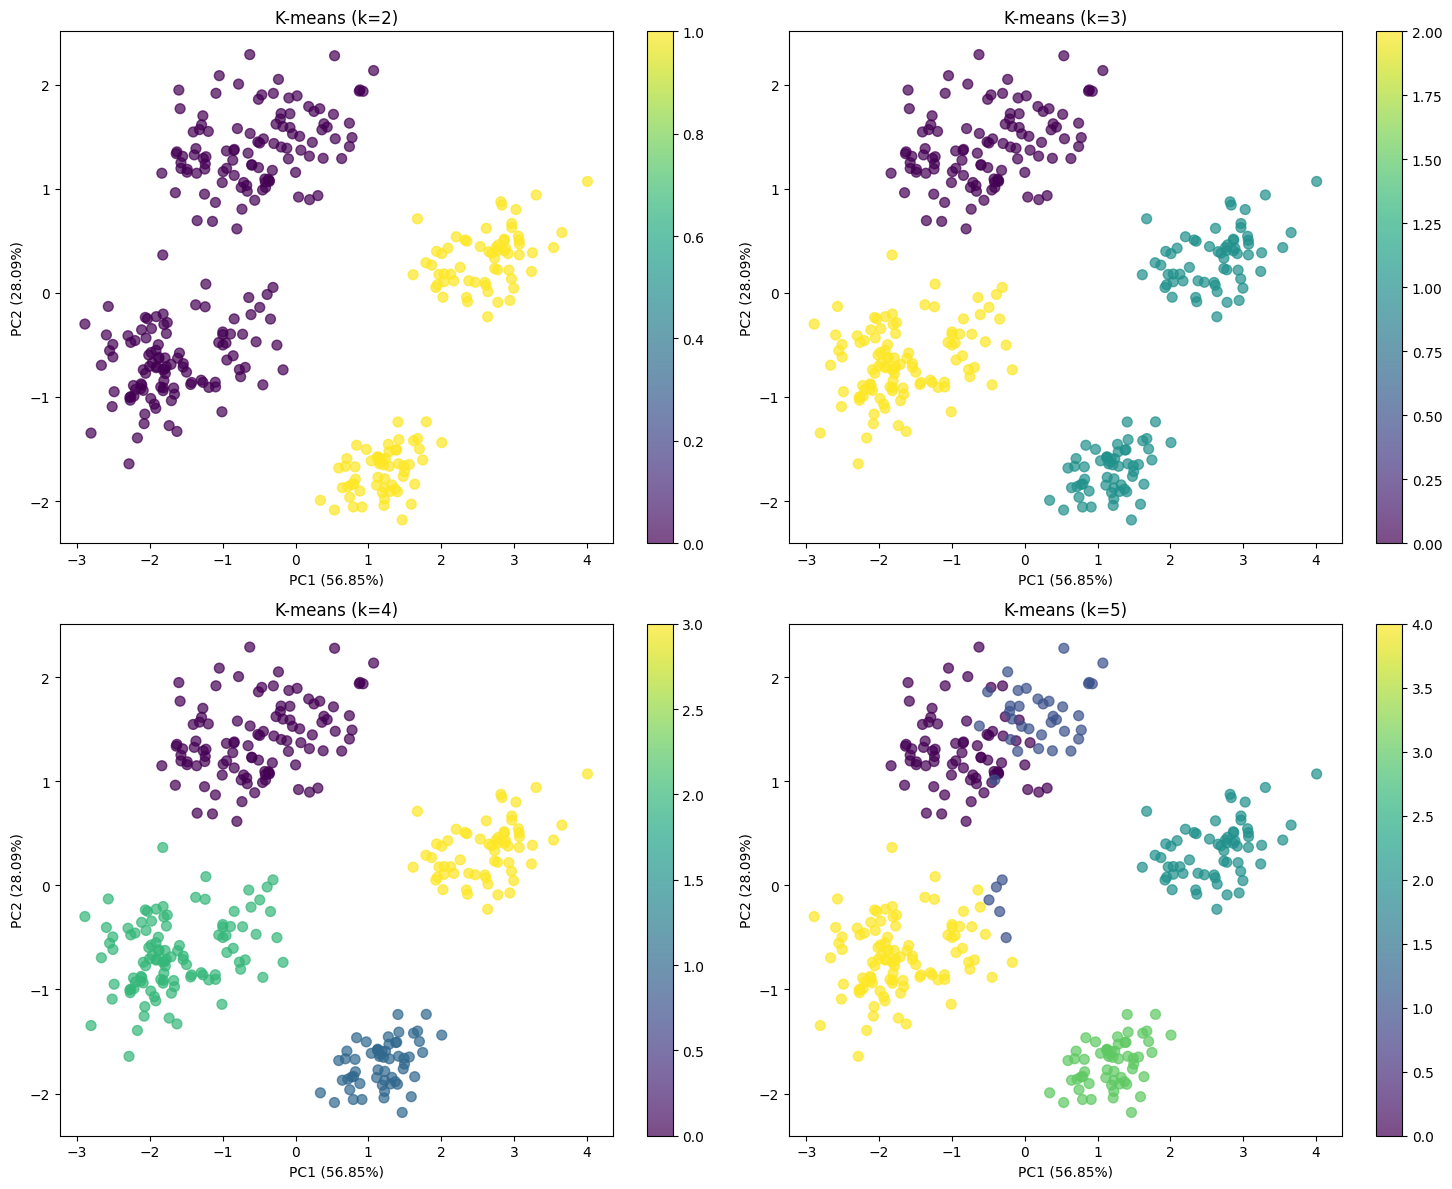

In [82]:
results = []

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    metrics = {}
    if len(np.unique(kmeans_labels)) > 1:
        metrics['silhouette'] = silhouette_score(X_scaled, kmeans_labels)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X_scaled, kmeans_labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X_scaled, kmeans_labels)
    else:
        metrics['silhouette'] = metrics['calinski_harabasz'] = metrics['davies_bouldin'] = np.nan

    cluster_stats = {}
    for label in np.unique(kmeans_labels):
        cluster_points = X_scaled[kmeans_labels == label]
        centroid = np.mean(cluster_points, axis=0)
        distances_to_center = np.linalg.norm(cluster_points - centroid, axis=1)
        
        cluster_stats[label] = {
            'size': len(cluster_points),
            'compactness': np.mean(distances_to_center),
            'intra_mean': np.mean(pdist(cluster_points)) if len(cluster_points) > 1 else 0,
            'radius': np.max(distances_to_center)
        }

    centroids = kmeans.cluster_centers_
    inter_distances = pdist(centroids)
    
    results.append({
        'k': k,
        'silhouette': metrics['silhouette'],
        'calinski_harabasz': metrics['calinski_harabasz'],
        'davies_bouldin': metrics['davies_bouldin'],
        'mean_inter_distance': np.mean(inter_distances),
        'min_inter_distance': np.min(inter_distances),
        'labels': kmeans_labels,
        'model': kmeans
    })

comparison_df = pd.DataFrame({
    'K': [result['k'] for result in results],
    'Silhouette': [f"{result['silhouette']:.4f}" for result in results],
    'Calinski-Harabasz': [f"{result['calinski_harabasz']:.2f}" for result in results],
    'Davies-Bouldin': [f"{result['davies_bouldin']:.4f}" for result in results],
    'Ср. межкл. расст.': [f"{result['mean_inter_distance']:.4f}" for result in results],
    'Мин. межкл. расст.': [f"{result['min_inter_distance']:.4f}" for result in results]
})

print("Сравнительная таблица метрик качества кластеризации K-means")
print(comparison_df.to_string(index=False))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, result in enumerate(results):
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=result['labels'], 
                             cmap='viridis', alpha=0.7, s=50)
    axes[i].set_title(f'K-means (k={result["k"]})')
    axes[i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    axes[i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.colorbar(scatter, ax=axes[i])

plt.tight_layout()
plt.show()

Исследование влияния количества кластеров k в методе K-means показало, что с увеличением k от 2 до 5 все метрики качества последовательно улучшаются, однако содержательный анализ выявил, что оптимальным является k=4, поскольку это значение обеспечивает наилучший баланс между метриками и интерпретируемостью кластеров, в то время как дальнейшее увеличение k до 5 приводит к излишнему дроблению кластеров и снижению минимального межкластерного расстояния с 2.396 до 2.0565, что ухудшает четкость границ между группами.